In [1]:
# -*- coding: utf-8 -*-
"""cs145_proj_YSUN.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1jPhmj_HgV3jkQXofoYxJJC1TjzBanB4Z
"""

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import sklearn
from scipy.signal import savgol_filter
from scipy.interpolate import UnivariateSpline
from sklearn.preprocessing import Normalizer
from sklearn import preprocessing
import statistics
from tqdm import tqdm
import copy
from random import randint
import math
from matplotlib import ticker
# from google.colab import files
from fbprophet import Prophet
import datetime


/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


{'Oregon', 'Indiana', 'Illinois', 'Wisconsin', 'Arizona', 'Florida', 'Vermont', 'New Jersey', 'Rhode Island', 'Virginia', 'Kentucky', 'Nebraska', 'Alaska', 'South Dakota', 'Pennsylvania', 'Arkansas', 'Ohio', 'Maryland', 'Alabama', 'Kansas', 'Tennessee', 'Colorado', 'North Carolina', 'Louisiana', 'Georgia', 'Nevada', 'Utah', 'West Virginia', 'Hawaii', 'Idaho', 'New Hampshire', 'Washington', 'South Carolina', 'Oklahoma', 'Massachusetts', 'Maine', 'North Dakota', 'Texas', 'Wyoming', 'Minnesota', 'Connecticut', 'New York', 'Mississippi', 'Michigan', 'New Mexico', 'California', 'Missouri', 'Montana', 'Iowa', 'Delaware'}
ADF Statistic: 1.904771
p-value: 0.998536


/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


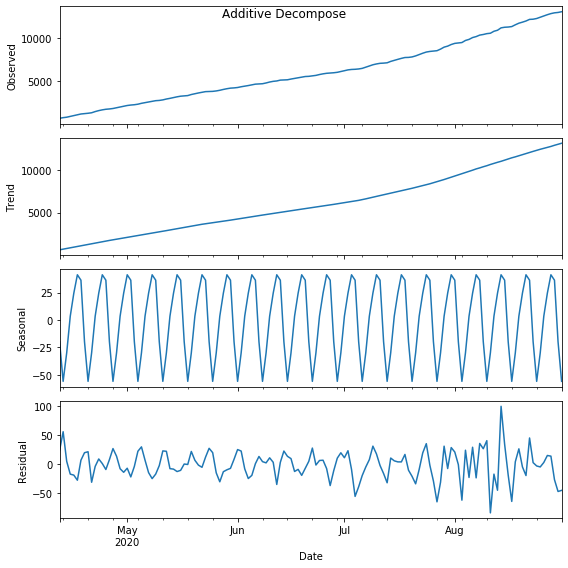

In [2]:
"""### ARIMA"""
state = 'California'
traindf = pd.read_csv('data/train.csv')
traindf.columns

print(set(traindf['Province_State'].values))
arima_train = traindf.copy()
arima_train.index = pd.DatetimeIndex(traindf.Date, freq = 'infer')
arima_train = arima_train.drop(["Date"], axis=1)

full_testdf = pd.read_csv('data/test-real.csv')

arima_test = full_testdf.copy()
arima_test.index = pd.DatetimeIndex(full_testdf.Date, freq = 'infer')
arima_test = arima_test.drop(["Date"], axis=1)

arima_train.tail()

arima_death_sample = arima_train[arima_train.Province_State == state].Deaths
arima_confirm_sample = arima_train[arima_train.Province_State == state].Confirmed

arima_death_sample_test = arima_test[arima_test.Province_State == state].Deaths
arima_confirm_sample_test = arima_test[arima_test.Province_State == state].Confirmed

arima_death = pd.concat([arima_death_sample, arima_death_sample_test])

arima_death.index = pd.DatetimeIndex(arima_death.index, freq = 'infer')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
additive = seasonal_decompose(arima_death_sample, model='additive', extrapolate_trend='freq')

additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

plt.rcParams.update({'figure.figsize': (8,8)})
additive.plot().suptitle('Additive Decompose')

from statsmodels.tsa.stattools import adfuller
trend = additive.trend
result = adfuller(trend.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
#p val ~= 0.99 > 0.05 so trend is stationary

Date
2020-04-12      636.071429
2020-04-13      713.923469
2020-04-14      791.775510
2020-04-15      873.428571
2020-04-16      950.142857
                  ...     
2020-08-27    12637.428571
2020-08-28    12749.857143
2020-08-29    12884.178571
2020-08-30    13003.397959
2020-08-31    13122.617347
Name: Deaths, Length: 142, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                  140
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -448.241
Method:                       css-mle   S.D. of innovations              5.930
Date:                Mon, 07 Dec 2020   AIC                            904.483
Time:                        02:02:11   BIC                            916.249
Sample:                    04-14-2020   HQIC                           909.264
                         - 08-31-2020                                         
                      co

/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


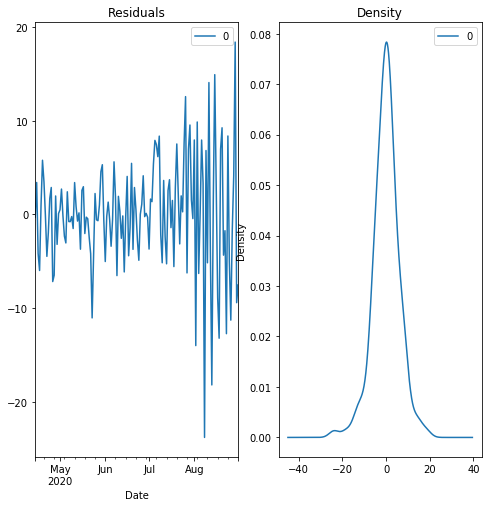

In [3]:
# from above, p=1, d=2, q=1
from statsmodels.tsa.arima_model import ARIMA
train = trend
print(trend)
# train = traindf.copy()
# train = train[train['Province_State']=='California']
# train.index = pd.DatetimeIndex(train.Date, freq='infer')
# train = train.drop(['Date'], axis=1)
# print(train)
# test = additive_test.trend
test = full_testdf.copy()
test.index = test['Date']
test=test.drop(['Date'], axis=1)
# print(test)

model = ARIMA(train, order=(1, 2, 1))
model = model.fit(disp=0)
print(model.summary())
#check P>|z| under ar. and ma. to see if model params fit

residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

Text(0.5, 0.98, '2nd Order Differencing')

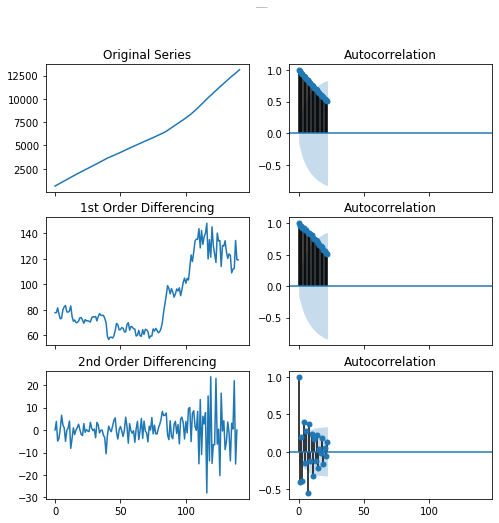

In [4]:
# IF trend is not stationary, (ours is)
# use differencing technique to make it stationary
# we use d = 2 here as 2nd order removes trend
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(trend.values); axes[0, 0].set_title('Original Series')
plot_acf(trend.values, ax=axes[0, 1]).suptitle('Original Series', fontsize=0)
# 1st Differencing
diff1 = trend.diff().dropna()
axes[1, 0].plot(diff1.values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1.values, ax=axes[1, 1]).suptitle('1st Order Differencing', fontsize=0)
# 2nd Differencing
diff2 = trend.diff().diff().dropna()
axes[2, 0].plot(diff2.values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2.values, ax=axes[2, 1]).suptitle('2nd Order Differencing', fontsize=0)

Text(0.5, 0.98, '1st Order Differencing')

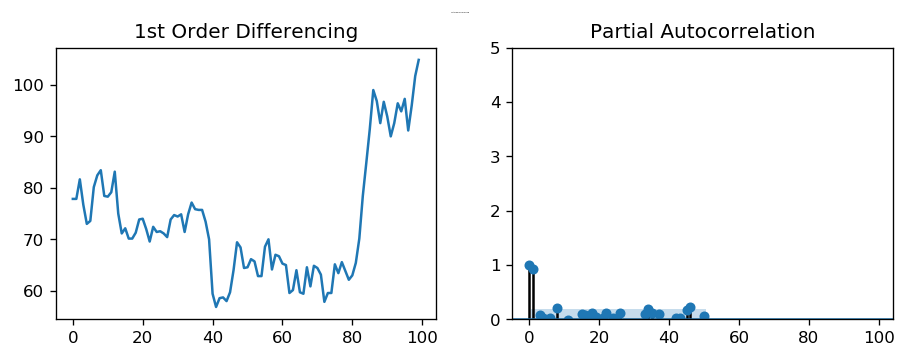

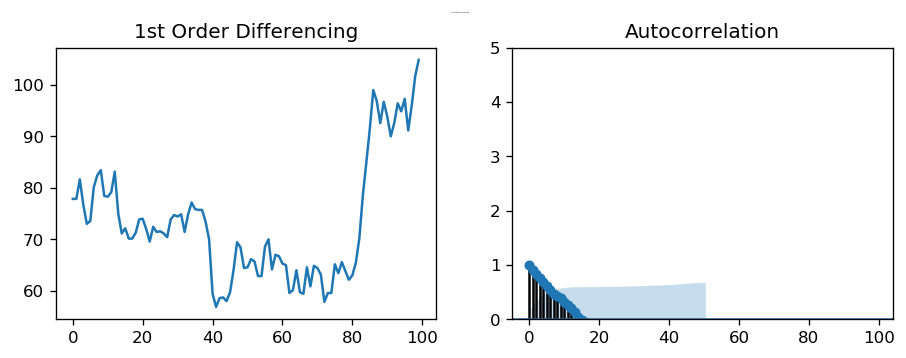

In [5]:
# autoregressive order p
# determined from PACF on nth order diff
# if well-above area shaded, then of order n
# here we use order 1, which works -> p = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) #finer dpi
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

# to get q, similarly, but use acf instead
# conclude that q = 1
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120}) #finer dpi
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_acf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

Date
2020-04-12      636.071429
2020-04-13      713.923469
2020-04-14      791.775510
2020-04-15      873.428571
2020-04-16      950.142857
                  ...     
2020-08-27    12637.428571
2020-08-28    12749.857143
2020-08-29    12884.178571
2020-08-30    13003.397959
2020-08-31    13122.617347
Name: Deaths, Length: 142, dtype: float64
                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                  140
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -448.241
Method:                       css-mle   S.D. of innovations              5.930
Date:                Mon, 07 Dec 2020   AIC                            904.483
Time:                        02:02:14   BIC                            916.249
Sample:                    04-14-2020   HQIC                           909.264
                         - 08-31-2020                                         
                      co

/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


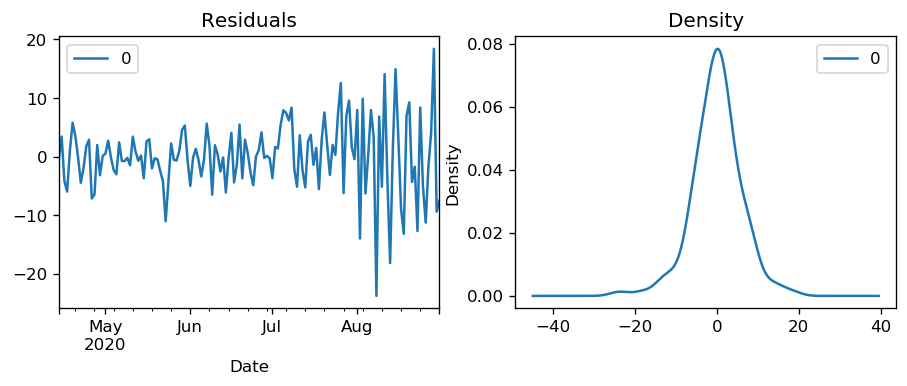

In [6]:
# from above, p=1, d=2, q=1
from statsmodels.tsa.arima_model import ARIMA
train = trend
print(trend)
# train = traindf.copy()
# train = train[train['Province_State']=='California']
# train.index = pd.DatetimeIndex(train.Date, freq='infer')
# train = train.drop(['Date'], axis=1)
# print(train)
# test = additive_test.trend
test = full_testdf.copy()
test.index = test['Date']
test=test.drop(['Date'], axis=1)
# print(test)

model = ARIMA(train, order=(1, 2, 1))
model = model.fit(disp=0)
print(model.summary())
#check P>|z| under ar. and ma. to see if model params fit

residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

                             ARIMA Model Results                              
Dep. Variable:              D2.Deaths   No. Observations:                  140
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -734.733
Method:                       css-mle   S.D. of innovations             45.300
Date:                Mon, 07 Dec 2020   AIC                           1477.465
Time:                        02:02:14   BIC                           1489.232
Sample:                    04-14-2020   HQIC                          1482.247
                         - 08-31-2020                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4635      0.125      3.723      0.000       0.219       0.708
ar.L1.D2.Deaths     0.2524      0.082      3.066      0.003       0.091       0.414
ma.L1.D2.Deaths    -1.0000      

/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
/Users/vincentl/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/Users/vincentl/anacon

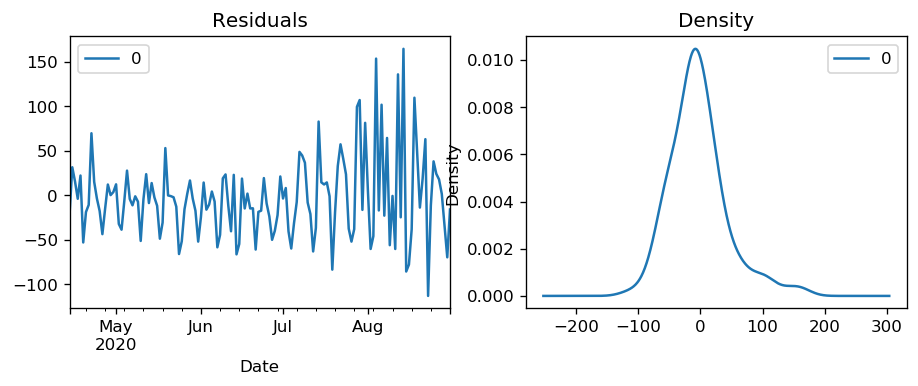

In [7]:
# from above, p=1, d=2, q=1
model = ARIMA(arima_death_sample, order=(1, 2, 1))
model = model.fit(disp=0)
print(model.summary())

residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])


Index(['09-01-2020', '09-02-2020', '09-03-2020', '09-04-2020', '09-05-2020',
       '09-06-2020', '09-07-2020', '09-08-2020', '09-09-2020', '09-10-2020',
       '09-11-2020', '09-12-2020', '09-13-2020', '09-14-2020', '09-15-2020',
       '09-16-2020', '09-17-2020', '09-18-2020', '09-19-2020', '09-20-2020',
       '09-21-2020', '09-22-2020', '09-23-2020', '09-24-2020', '09-25-2020',
       '09-26-2020'],
      dtype='object', name='Date')
Date
09-01-2020    13133.905996
09-02-2020    13252.950392
09-03-2020    13374.143235
09-04-2020    13496.224908
09-05-2020    13618.877444
09-06-2020    13742.020578
09-07-2020    13865.634049
09-08-2020    13989.712743
09-09-2020    14114.255368
09-10-2020    14239.261599
09-11-2020    14364.731353
09-12-2020    14490.664609
09-13-2020    14617.061363
09-14-2020    14743.921612
09-15-2020    14871.245358
09-16-2020    14999.032598
09-17-2020    15127.283335
09-18-2020    15255.997566
09-19-2020    15385.175293
09-20-2020    15514.816516
09-21-2020   

<Figure size 1080x360 with 0 Axes>

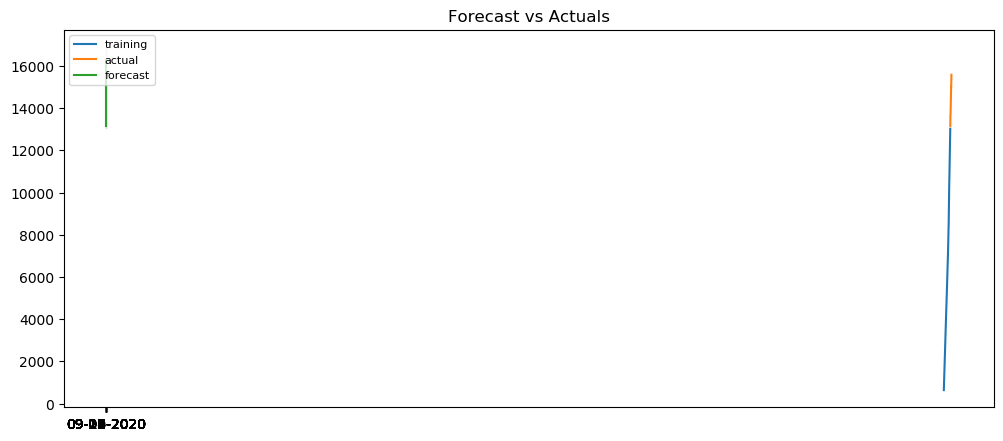

In [8]:
# Forecast: 192 forecasting values with 95% confidence
test =  test[test['Province_State']=='California']
fc, se, conf = model.forecast(test.shape[0], alpha=0.05)
# Make as pandas series
print(test.index)
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
print(fc_series)
# Plot
plt.figure()
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_death_sample, label='training')
plt.plot(arima_death_sample_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


In [9]:
"""#### Change state"""

state = "Hawaii"

test = pd.read_csv('data/test-real.csv')
test = test[test['Province_State']==state]
test.index = test['Date']
teset = test.drop(['Date'], axis=1)
print(test)


arima_death_ex = arima_train[arima_train.Province_State == state].Deaths
arima_death_ex_test = arima_test[arima_test.Province_State == state].Deaths

# from above, p=1, d=2, q=1
model = ARIMA(arima_death_ex, order=(1, 1, 1))   #121 best for Idaho
                                                 #111 best for Hawaii
model = model.fit(disp=0)
print(model.summary())

# Forecast: 192 forecasting values with 95% confidence
fc, se, conf = model.forecast(test.shape[0], alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(arima_death_ex[-50:], label='training')
plt.plot(arima_death_ex_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

            ForecastID Province_State        Date  Confirmed  Deaths
Date                                                                
09-01-2020          10         Hawaii  09-01-2020       8653      74
09-02-2020          60         Hawaii  09-02-2020       8991      75
09-03-2020         110         Hawaii  09-03-2020       9202      79
09-04-2020         160         Hawaii  09-04-2020       9473      81
09-05-2020         210         Hawaii  09-05-2020       9693      84
09-06-2020         260         Hawaii  09-06-2020       9855      85
09-07-2020         310         Hawaii  09-07-2020       9959      86
09-08-2020         360         Hawaii  09-08-2020      10025      88
09-09-2020         410         Hawaii  09-09-2020      10123      91
09-10-2020         460         Hawaii  09-10-2020      10292      94
09-11-2020         510         Hawaii  09-11-2020      10459      96
09-12-2020         560         Hawaii  09-12-2020      10588      97
09-13-2020         610         Haw

/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/vincentl/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ValueError: The computed initial AR coefficients are not stationary
You should induce stationarity, choose a different model order, or you can
pass your own start_params.

In [ ]:
"""#### Alternative model params"""

# from above, p=1, d=2, q=1
model = ARIMA(train, order=(1, 1, 1))
model = model.fit(disp=0)
print(model.summary())
#check P>|z| under ar. and ma. to see if model params fit

residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

plt.plot(full_testdf[full_testdf.Province_State == "Alaska"].Deaths)

# Forecast: 192 forecasting values with 95% confidence
fc, se, conf = model.forecast(26, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
